In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [3]:
df_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB


In [4]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Russia - Sberbank Rossii PAO Stocks

In [5]:
df = timeseries_preprocessing(df_ru)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 310 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    311 non-null    datetime64[ns]
 1   Price   311 non-null    float64       
 2   Open    311 non-null    float64       
 3   High    311 non-null    float64       
 4   Low     311 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.6 KB


In [6]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

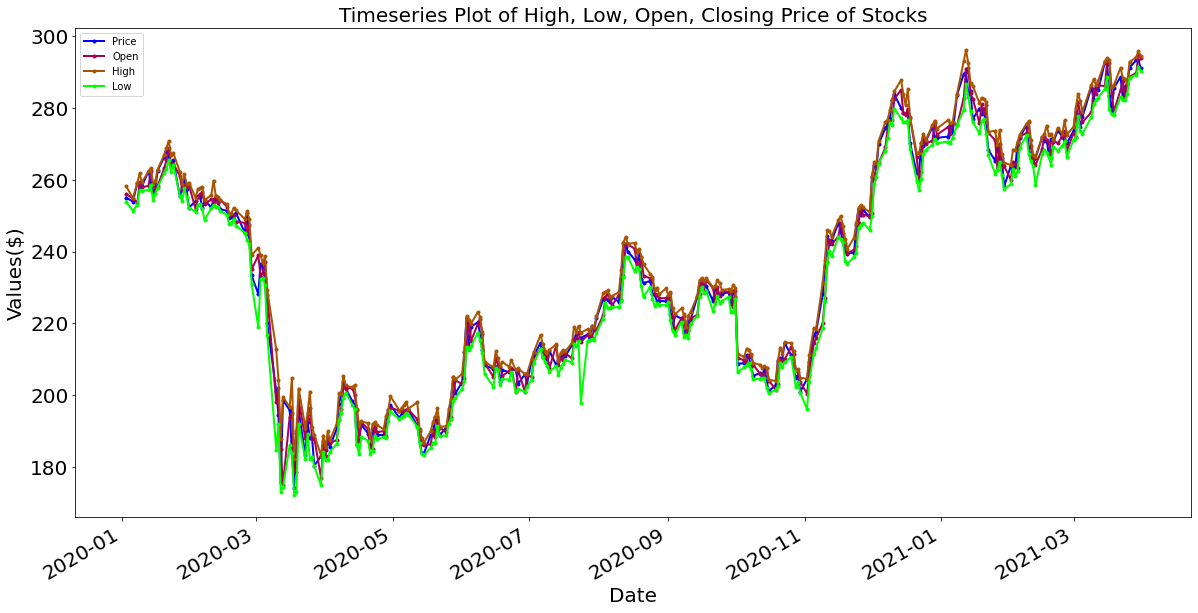

In [7]:
timeseries_plot(df)

In [8]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

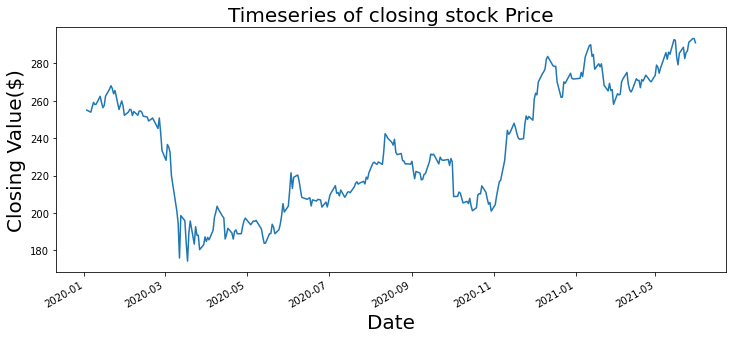

In [9]:
timeseries_plot_closing_value(df)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


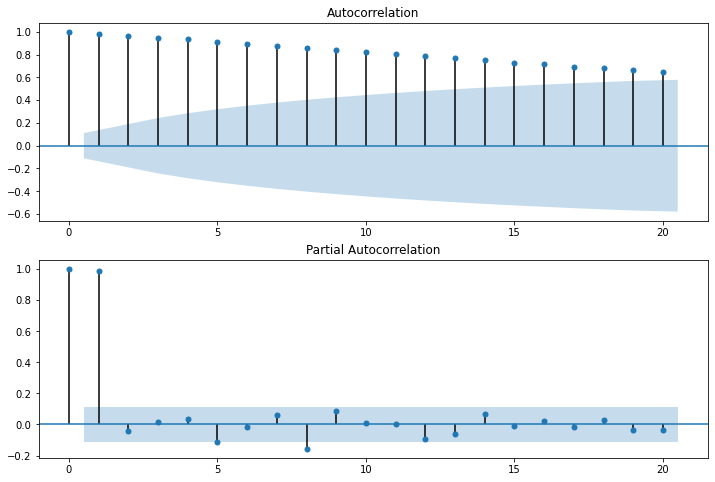

In [11]:
acf_pacf_plot(df)

# Dickey Fuller Test

In [12]:
#If the dataset is not stationary--

def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [13]:
df = stationary(df)

The p-value is 0.7582066363876817 reject the null hypthesis and data is not stationary
The p-value after first difference is 4.614666802732984e-07, accept the null hypothesis and data is stationary


In [14]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
309,2020-01-06,253.90,254.75,254.84,251.40,-1.10
308,2020-01-08,259.15,253.57,259.15,253.03,5.25
307,2020-01-09,257.99,259.40,261.76,257.01,-1.16
306,2020-01-10,258.19,257.86,259.25,256.88,0.20
305,2020-01-13,262.40,258.30,262.40,257.15,4.21
...,...,...,...,...,...,...
4,2021-03-25,286.66,286.50,287.03,283.85,0.87
3,2021-03-26,291.22,288.63,292.75,288.32,4.56
2,2021-03-29,293.30,289.72,294.09,289.26,2.08
1,2021-03-30,293.25,294.86,295.72,291.50,-0.05


In [15]:
df_final = df.set_index('Date')

In [16]:
df_final.tail()

,Price,Open,High,Low,Difference
Date,,,,,
2021-03-25,286.66,286.50,287.03,283.85,0.87
2021-03-26,291.22,288.63,292.75,288.32,4.56
2021-03-29,293.30,289.72,294.09,289.26,2.08
2021-03-30,293.25,294.86,295.72,291.50,-0.05
2021-03-31,291.02,294.00,294.42,290.26,-2.23


In [17]:
df_train = df_final.loc[:'2020']
df_test = df_final.loc['2021':]

In [18]:
#use a for loop for testing data! for 61 days

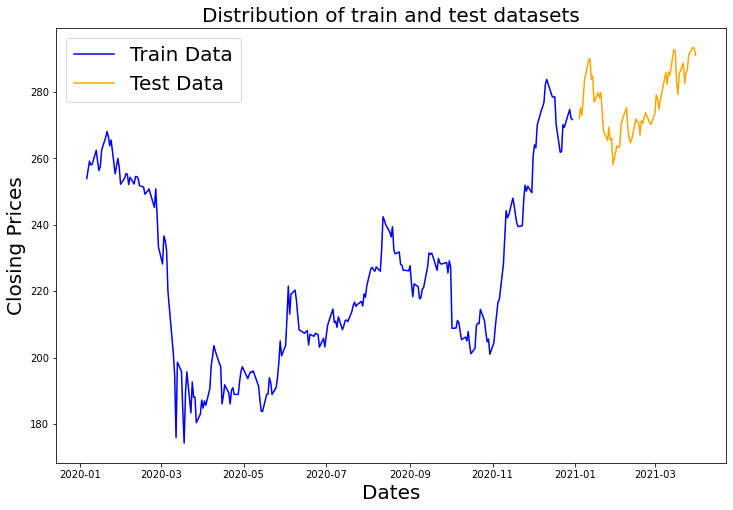

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_train['Price'],color='blue', label='Train Data')
plt.plot(df_test['Price'],color='orange', label='Test Data')
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Closing Prices',fontsize=20)
plt.legend(loc='upper left',fontsize=20)
plt.title('Distribution of train and test datasets',fontsize=20)
plt.show()

In [20]:
df_train

,Price,Open,High,Low,Difference
Date,,,,,
2020-01-06,253.90,254.75,254.84,251.40,-1.10
2020-01-08,259.15,253.57,259.15,253.03,5.25
2020-01-09,257.99,259.40,261.76,257.01,-1.16
2020-01-10,258.19,257.86,259.25,256.88,0.20
2020-01-13,262.40,258.30,262.40,257.15,4.21
...,...,...,...,...,...
2020-12-24,269.32,271.98,272.82,267.13,-0.78
2020-12-25,270.64,269.97,271.00,268.28,1.32
2020-12-28,274.70,270.90,275.19,269.73,4.06


In [21]:
df_test

,Price,Open,High,Low,Difference
Date,,,,,
2021-01-04,272.00,274.67,276.60,270.61,0.35
2021-01-05,275.20,272.69,275.70,270.28,3.20
2021-01-06,272.93,275.94,275.94,271.62,-2.27
2021-01-08,283.64,275.11,283.99,275.11,10.71
2021-01-11,289.49,282.86,292.95,279.48,5.85
...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,0.87
2021-03-26,291.22,288.63,292.75,288.32,4.56
2021-03-29,293.30,289.72,294.09,289.26,2.08


## ARIMA Model

In [22]:
 arima_model = pm.auto_arima(df_train.Price, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [23]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -739.729
Date:                Thu, 23 Jun 2022   AIC                           1493.459
Time:                        12:29:04   BIC                           1518.053
Sample:                             0   HQIC                          1503.360
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2108      1.001      0.210      0.833      -1.752       2.174
ar.L1         -1.1497      0.159     -7.246      0.000      -1.461      -0.839
ar.L2         -0.6702      0.156     -4.284      0.0

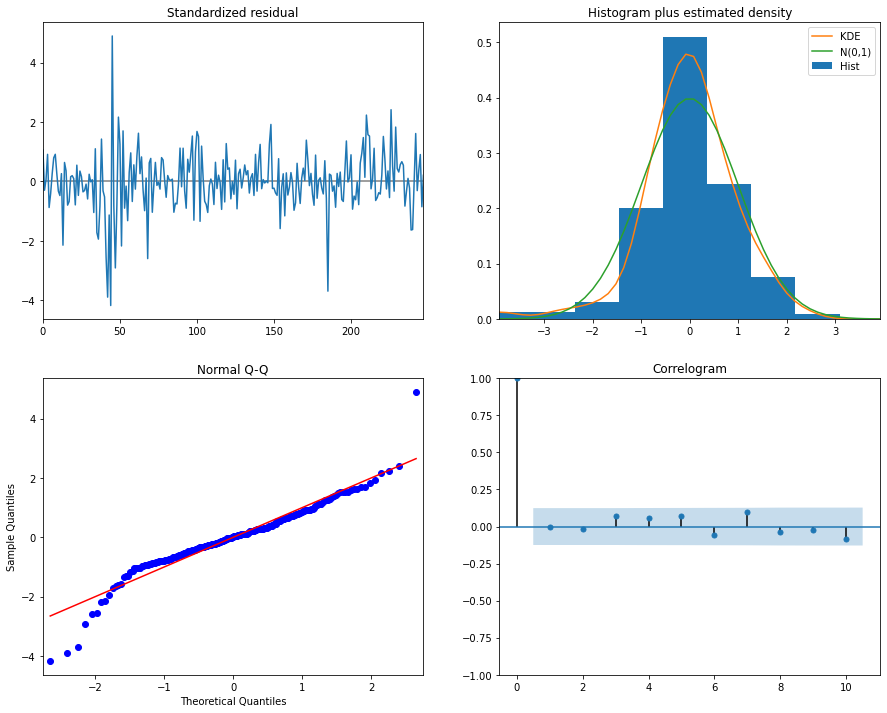

In [24]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [25]:
arima = statsmodels.tsa.arima.model.ARIMA(df_train.Price,order=(2,1,3))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [26]:
arima_fit = arima.fit()

In [27]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  249
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -739.759
Date:                Thu, 23 Jun 2022   AIC                           1491.518
Time:                        12:29:05   BIC                           1512.598
Sample:                             0   HQIC                          1500.004
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1501      0.157     -7.327      0.000      -1.458      -0.842
ar.L2         -0.6704      0.151     -4.430      0.000      -0.967      -0.374
ma.L1          1.2211      0.150      8.116      0.0

In [28]:
y_pred = arima_model.predict(len(df_test['Price']))

In [29]:
y_pred

array([272.00484052, 273.09308132, 271.7359268 , 272.77771824,
       272.70026421, 272.30189136, 273.02258468, 272.67174276,
       272.80288348, 273.09800598, 272.8815788 , 273.14339125,
       273.1981956 , 273.17049229, 273.37638296, 273.36900187,
       273.45027212, 273.57254967, 273.58826772, 273.69901665,
       273.77192138, 273.82464809, 273.92593639, 273.98491556,
       274.05999308, 274.14491695, 274.20773144, 274.2893666 ,
       274.36418066, 274.43422376, 274.5143235 , 274.58605836,
       274.66067067, 274.73758074, 274.80992062, 274.885975  ,
       274.96082162, 275.03456743, 275.11038828, 275.18456116,
       275.25923808, 275.33443994, 275.40870047, 275.48369146,
       275.55847349, 275.63300623, 275.70796562, 275.78260155,
       275.85732343, 275.93216328, 276.00680989, 276.08159961,
       276.1563543 , 276.23105335, 276.30583985, 276.3805631 ,
       276.45530046, 276.53006398, 276.60478797, 276.67953988,
       276.75428618])

In [30]:
fc = len(df_test['Price'])
fc_series = pd.Series(y_pred,index=df_test['Price'].index)

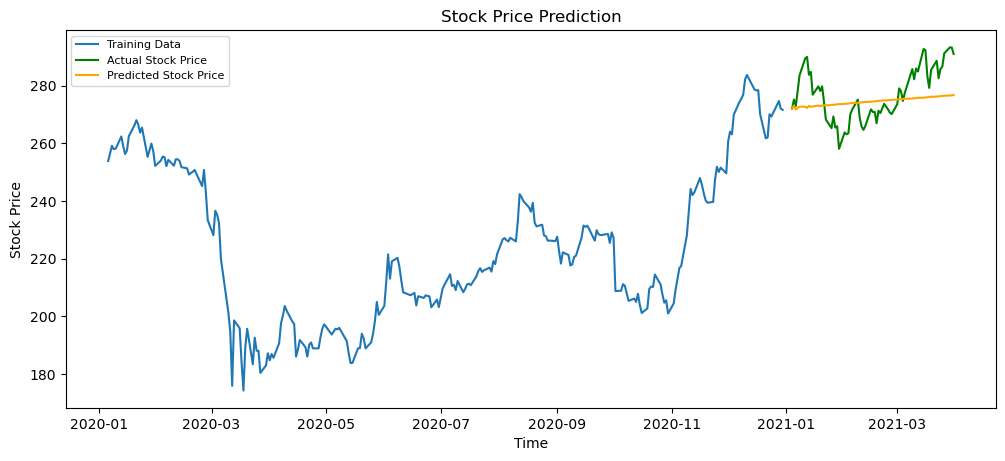

In [32]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df_train.Price,label='Training Data')
plt.plot(df_test.Price,color='green',label='Actual Stock Price')
plt.plot(fc_series,color='orange',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [33]:
fc_series

Date
2021-01-04    272.004841
2021-01-05    273.093081
2021-01-06    271.735927
2021-01-08    272.777718
2021-01-11    272.700264
                 ...    
2021-03-25    276.455300
2021-03-26    276.530064
2021-03-29    276.604788
2021-03-30    276.679540
2021-03-31    276.754286
Length: 61, dtype: float64

In [34]:
mape = np.mean(np.abs(fc-df_test['Price'])/np.abs(df_test['Price']))
print(mape)

0.7793624016276506


In [35]:
 mean_absolute_error(df_test.Price, y_pred)

7.418850381886011

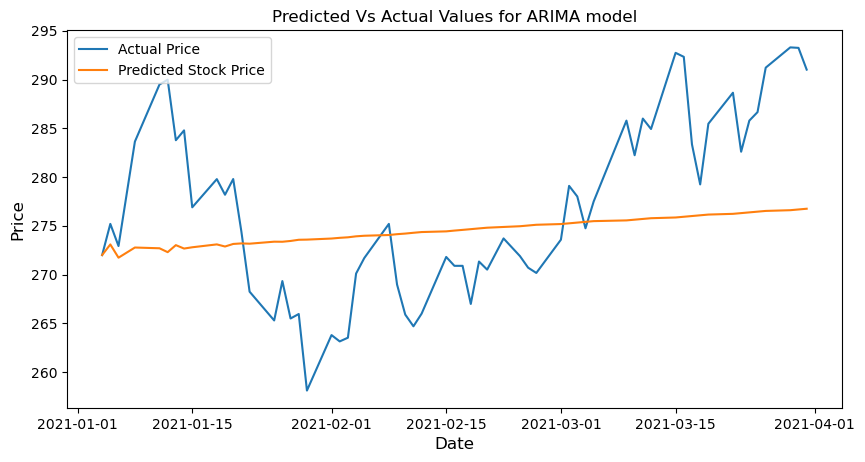

In [36]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df_test.Price,label='Actual Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.title('Predicted Vs Actual Values for ARIMA model')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

## Time Series Cross Validation

Observations: 156
Training Observations: 79
Testing Observations: 77


<Figure size 432x288 with 0 Axes>

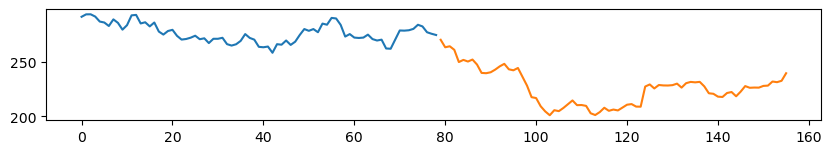

Observations: 233
Training Observations: 156
Testing Observations: 77


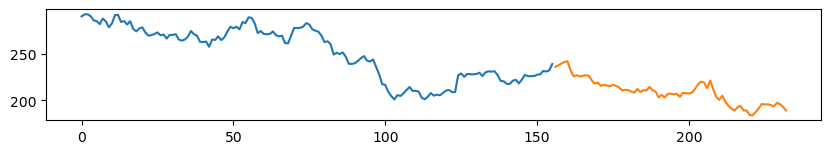

Observations: 310
Training Observations: 233
Testing Observations: 77


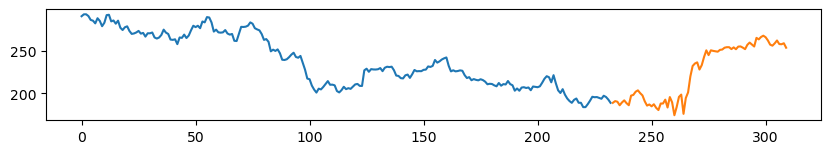

In [37]:

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df.Price
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.figure(figsize=(10,5),dpi=100)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
    pyplot.show()

In [39]:
from matplotlib import pyplot

X = df.Price
n_train = 249
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=249, test=1
train=250, test=1
train=251, test=1
train=252, test=1
train=253, test=1
train=254, test=1
train=255, test=1
train=256, test=1
train=257, test=1
train=258, test=1
train=259, test=1
train=260, test=1
train=261, test=1
train=262, test=1
train=263, test=1
train=264, test=1
train=265, test=1
train=266, test=1
train=267, test=1
train=268, test=1
train=269, test=1
train=270, test=1
train=271, test=1
train=272, test=1
train=273, test=1
train=274, test=1
train=275, test=1
train=276, test=1
train=277, test=1
train=278, test=1
train=279, test=1
train=280, test=1
train=281, test=1
train=282, test=1
train=283, test=1
train=284, test=1
train=285, test=1
train=286, test=1
train=287, test=1
train=288, test=1
train=289, test=1
train=290, test=1
train=291, test=1
train=292, test=1
train=293, test=1
train=294, test=1
train=295, test=1
train=296, test=1
train=297, test=1
train=298, test=1
train=299, test=1
train=300, test=1
train=301, test=1
train=302, test=1
train=303, test=1
train=304,

In [40]:
x = df_final['Price']
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(2,1,3)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

             Price  predictions_wf
Date                              
2021-03-31  291.02      292.241319


In [41]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(2,1,3)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

             Price  predictions_wf
Date                              
2021-02-16  270.90      271.011020
2021-02-17  270.90      271.769665
2021-02-18  266.99      270.241078
2021-02-19  271.34      267.085926
2021-02-20  270.51      271.927922
2021-02-22  273.71      270.314165
2021-02-24  271.90      273.516772
2021-02-25  270.71      272.653374
2021-02-26  270.17      269.701201
2021-03-01  273.58      271.030002
2021-03-02  279.10      273.762315
2021-03-03  278.01      278.933152
2021-03-04  274.75      278.389878
2021-03-05  277.50      274.021317
2021-03-09  285.79      278.059854
2021-03-10  282.24      286.413177
2021-03-11  286.00      281.069778
2021-03-12  284.93      286.599803
2021-03-15  292.74      285.808101
2021-03-16  292.33      291.490736
2021-03-17  283.35      293.939305
2021-03-18  279.25      281.679082
2021-03-19  285.47      279.864797
2021-03-22  288.65      287.352865
2021-03-23  282.60      286.945059
2021-03-24  285.79      282.783086
2021-03-25  286.66  

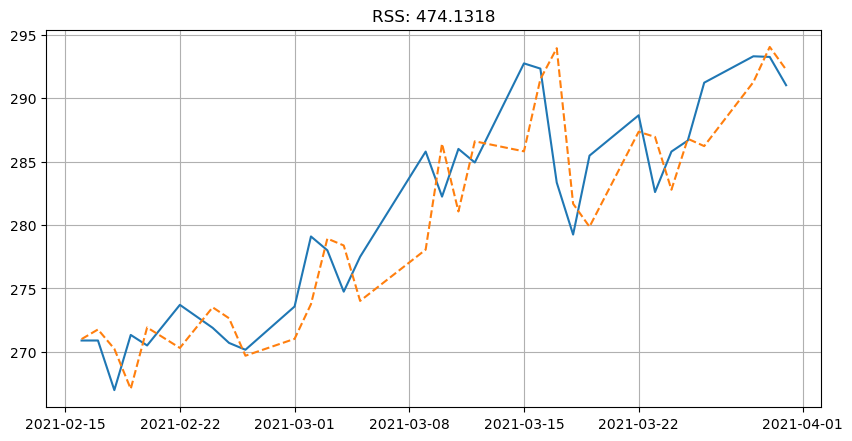

Test RMSE for ARIMA with Walk-Forward Validation:  3.910827749824087


In [42]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(test_['Price'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Price'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [43]:
mape = np.mean(np.abs(prediction-test.values)/np.abs(test.values))
print(mape)

0.010986596485468373


# LSTM Model

In [44]:
df = timeseries_preprocessing(df_ru)

In [45]:
df

,Date,Price,Open,High,Low
309,2020-01-06,253.90,254.75,254.84,251.40
308,2020-01-08,259.15,253.57,259.15,253.03
307,2020-01-09,257.99,259.40,261.76,257.01
306,2020-01-10,258.19,257.86,259.25,256.88
305,2020-01-13,262.40,258.30,262.40,257.15
...,...,...,...,...,...
4,2021-03-25,286.66,286.50,287.03,283.85
3,2021-03-26,291.22,288.63,292.75,288.32
2,2021-03-29,293.30,289.72,294.09,289.26
1,2021-03-30,293.25,294.86,295.72,291.50


In [46]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [47]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [48]:
train_test_boundary

61

In [49]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [50]:
df = df.set_index('Date')

In [51]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-06,253.90,254.75,254.84,251.40,2020
2020-01-08,259.15,253.57,259.15,253.03,2020
2020-01-09,257.99,259.40,261.76,257.01,2020
2020-01-10,258.19,257.86,259.25,256.88,2020
2020-01-13,262.40,258.30,262.40,257.15,2020
...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,2021
2021-03-26,291.22,288.63,292.75,288.32,2021
2021-03-29,293.30,289.72,294.09,289.26,2021


In [52]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [53]:
#global variables
n_steps = 3
n_features = 1


In [54]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [55]:
#defining the training dataframe
train_df = df[:-train_test_boundary]
    
#defining the testing dataframe
test_df = df[-train_test_boundary:]

In [56]:
train_df.shape

(249, 4)

In [57]:
test_df.shape

(61, 4)

In [58]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [59]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [60]:
X_train.shape,y_train.shape

((246, 3, 1), (246,))

In [61]:
X_test.shape,y_test.shape

((58, 3, 1), (58,))

In [62]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [63]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [64]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-10,258.19,256.722084
2020-01-13,262.40,258.816189
2020-01-14,259.05,259.336674
2020-01-15,256.31,260.023097
2020-01-16,257.51,260.256869
...,...,...
2021-03-25,286.66,289.193968
2021-03-26,291.22,287.060062
2021-03-29,293.30,290.372199


In [65]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 6.535910493448036


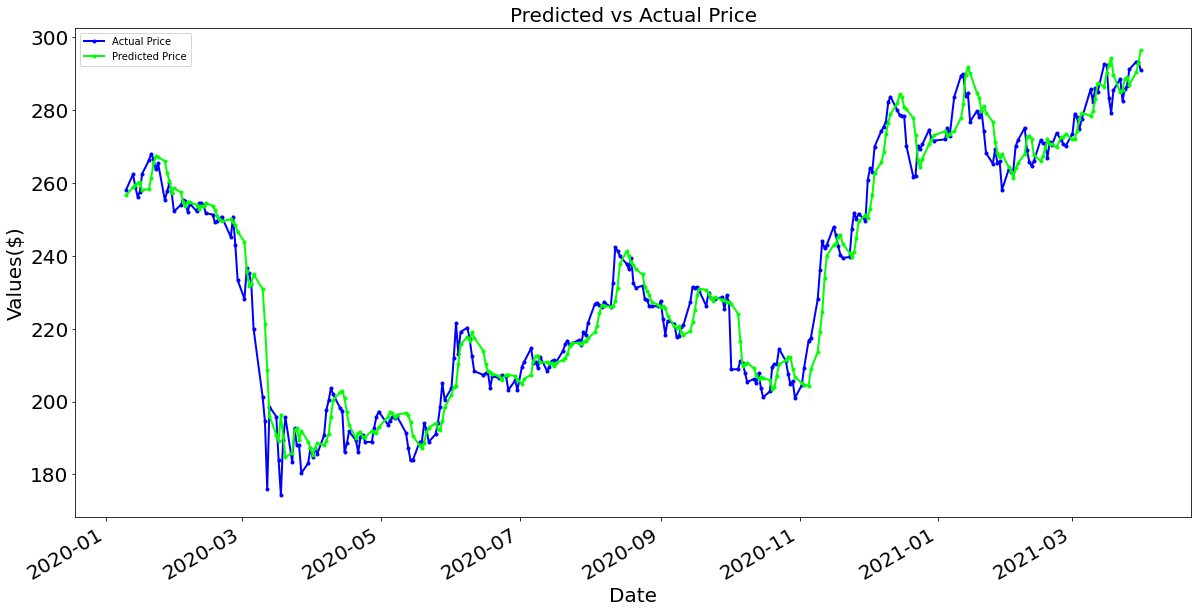

In [66]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

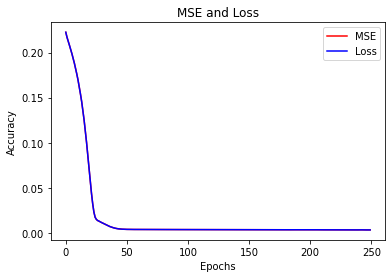

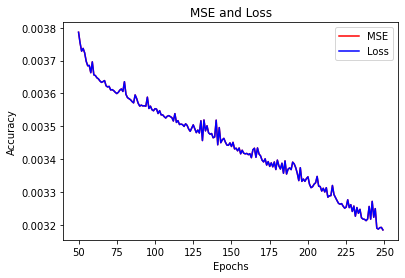

<Figure size 432x288 with 0 Axes>

In [67]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])


plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [68]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [69]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $50565.76000000001 with sma of 70 using a bollinger parameter 40


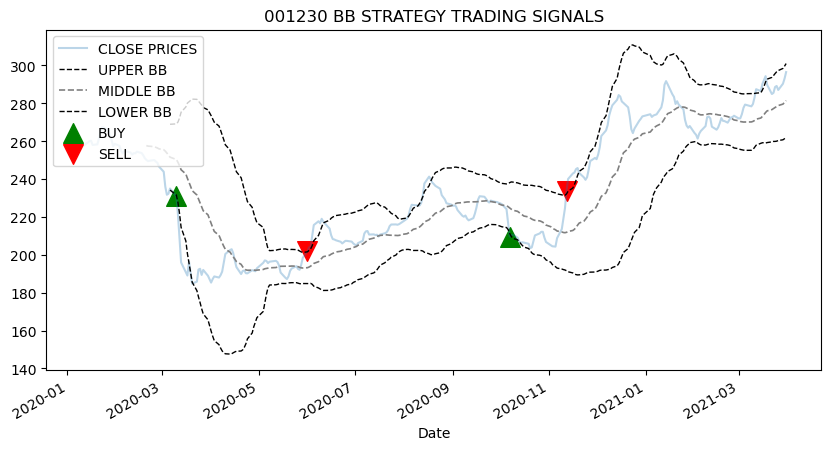

In [70]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)
plt.figure(figsize=(10,5),dpi=100)
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()